This notebook performs linear regression on our honey production and air quality combined dataset, which is read in in the second cell<br>
We use the matrix solution to minimize the MSE<br>
Cross validation is performed and an MSE is output near the end. Everything is written from scratch with numpy

In [1]:
import pandas as pd
from scipy.stats import norm
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("data/completeFeatureVectors.csv")

X = data[['o3','co','so2','no2','pm25_frm', 'pressure', 'temperature', 'wind', 'year']].to_numpy()
# subtract 1998 from the year so that it starts at zero
X[:,8] = X[:,8]-1998
# Append ones to the start of X for the bias term
X = np.append(np.ones((X.shape[0],1)), X, axis=1)
y = data[['yield_per_col']].to_numpy()

Minimize the MSE by using the matrix formula to find theta.<br>
Also find the variance sigma so that we can find confidence intervals for our predictions

In [3]:
np.set_printoptions(suppress=True) # disable scientific notation when printing

theta = np.matmul(np.matmul(np.linalg.inv(np.matmul(X.T, X)),X.T),y)

# print out theta with labels
for label,theta_i in zip(['intercept','o3','co','so2','no2','pm25_frm','pressure','temperature','wind','year'], theta):
    print(label + ": " + "{:f}".format(theta_i[0]))

intercept: 122.059749
o3: -590.575726
co: -18.605731
so2: 0.889749
no2: 0.070241
pm25_frm: -0.160325
pressure: 0.002724
temperature: 0.251869
wind: -0.407970
year: -1.690834


Make a prediction and show a 95% confidence interval for that prediction

In [4]:
x = np.array([[1],[0.0312],[0.759],[1.575],[14.757],[43.9],[984.],[59.17],[97.27], [10]])
prediction = np.matmul(x.T, theta)[0][0]
print("prediction:", prediction)

# find variance sigma and find a 95% confidence interval
sigma_sq = (np.matmul((y-np.matmul(X, theta)).T,(y-np.matmul(X, theta))) / X.shape[0]-1)[0][0]
sigma = math.sqrt(sigma_sq)
dev = sigma_sq*np.matmul(np.matmul(x.T,np.linalg.inv(np.matmul(X.T,X))),x)[0][0]
print("dev:", dev) # getting 190... seems very high, not sure how to confirm
ppf = norm.ppf(0.975, loc=0, scale=dev) # how ppf works: https://stackoverflow.com/questions/60699836/how-to-use-norm-ppf
print("ppf:", ppf)
rng = ppf*sigma # ppf returns a standard deviation multiplier, so we need to multiply by the stdev to get the true value

print("range:", rng)
print("95% conf. Lower bound:", prediction-rng)
print("95% conf. Upper bound:", prediction+rng)

prediction: 45.903915345153344
dev: 110.50935630007413
ppf: 216.59435830284983
range: 2965.7431994768845
95% conf. Lower bound: -2919.839284131731
95% conf. Upper bound: 3011.647114822038


Determine which features are significant using the inverse tail of chi squared function

In [5]:
cov_matrix = sigma_sq*np.linalg.inv(np.matmul(X.T,X))
threshold = 0.2357 # inverse tail of chi squared(?) function
features = ['intercept','o3','co','so2','no2','pm25_frm','pressure','temperature','wind','year']
for i in range(theta.shape[0]):
    sig = (theta[i,:][0] / cov_matrix[i,i])**2
    if sig > threshold:
        print(str(i) + ": " + features[i] + ": significant")
    else:
        print(str(i) + ": " + features[i] + ": not significant")

0: intercept: significant
1: o3: not significant
2: co: significant
3: so2: significant
4: no2: significant
5: pm25_frm: significant
6: pressure: significant
7: temperature: significant
8: wind: significant
9: year: significant


Perform k-fold cross validation to find our mean squared error (MSE)

Mean squared error: 207.66410119000454
Median squared error: 97.33642347380766
Mean absolute error: 11.410404538487048


Text(0.5, 1.0, 'Distribution Squared Error Terms')

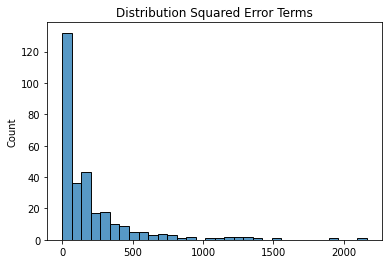

In [6]:
k = 10

# the size of the testing set for each fold
chunk_size = X.shape[0] // k

# shuffle X and y together
Xy_shuffled = np.append(X, y, axis=1)
np.random.shuffle(Xy_shuffled)

sq_errors = []
abs_errors = []

# iterate through k folds
for i in range(k):

    # split out testing and training data
    X_k_test = Xy_shuffled[chunk_size*i:chunk_size*(i+1),:10]
    y_k_test = Xy_shuffled[chunk_size*i:chunk_size*(i+1),10]

    if i == 0:
        X_k_train = Xy_shuffled[chunk_size:,:10]
        y_k_train = Xy_shuffled[chunk_size:,10]
    elif i == k-1:
        X_k_train = Xy_shuffled[:chunk_size*i,:10]
        y_k_train = Xy_shuffled[:chunk_size*i,10]
    else:
        X_k_train = np.append(Xy_shuffled[:chunk_size*i,:10], Xy_shuffled[chunk_size*(i+1):,:10], axis=0)
        y_k_train = np.append(Xy_shuffled[:chunk_size*i,10], Xy_shuffled[chunk_size*(i+1):,10], axis=0)

    # train on training data to get theta_k
    theta_k = np.matmul(np.matmul(np.linalg.inv(np.matmul(X_k_train.T, X_k_train)),X_k_train.T),y_k_train)
    # test out the theta_k that we found on the testing chunk
    for i in range(X_k_test.shape[0]):
        y_pred = np.matmul(X_k_test[i,:].T, theta_k)
        y_actual = y_k_test[i]
        #print("predicted:", y_pred, "actual", y_actual)
        sq_errors.append((y_pred - y_actual)**2)
        abs_errors.append(abs(y_pred-y_actual))
    
mean_sq_error = np.mean(sq_errors)
mean_abs_error = np.mean(abs_errors)
print("Mean squared error:", mean_sq_error)
print("Median squared error:", np.median(sq_errors))
print("Mean absolute error:", mean_abs_error)

sns.histplot(data=sq_errors).set_title("Distribution Squared Error Terms")